# Sentiment Analysis of Twitter Posts

<!-- Notebook name goes here -->
<center><b>Notebook: MultiNaive Bayes Model, Error Analysis, and Tuning</b></center>
<br>

**By**: Stephen Borja, Justin Ching, Erin Chua, and Zhean Ganituen.

**Dataset**: Hussein, S. (2021). Twitter Sentiments Dataset [Dataset]. Mendeley. https://doi.org/10.17632/Z9ZW7NT5H2.1

**Motivation**: Every minute, social media users generate a large influx of textual data on live events. Performing sentiment analysis on this data provides a real-time view of public perception, enabling quick insights into the general population’s opinions and reactions.

**Goal**: By the end of the project, our goal is to create and compare supervised learning algorithms for sentiment analysis.


# **1. Project Set-up**


In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    StratifiedKFold,
    GridSearchCV,
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath("../lib"))
from anal_ysis_tools import (
    report_classification_performance,
    report_unseen_test_words,
    report_misleading_words_by_lift,
    compare_word_usage_wrong_vs_right,
)

# **2. Data Set-up**


In [2]:
import IPython.core.page
import builtins
from IPython.utils.capture import capture_output

pager = IPython.core.page.page
helper = builtins.help

IPython.core.page.page = lambda *args, **kwargs: None
builtins.help = lambda *args, **kwargs: None

try:
    with capture_output():
        %run data.ipynb
finally:
    IPython.core.page.page = pager
    builtins.help = helper

print("Data Setup is DONE")

# Tests
assert X.shape == (162_801, 29318), "Feature matrix shape is wrong; expected (162_801, 29318)"
assert y.shape == (162_801,), "Labels shape is wrong; expected (162_801,)"

assert X_train.shape == (113_960, 29_318), "Train shape is wrong; expected (113_960, 2)"
assert X_test.shape == (48_841, 29_318), "Test shape is wrong; expected (48_841, 2)"

assert y_train.shape == (113_960,), "Train labels shape is wrong; expected (113_960,)"
assert y_test.shape == (48_841,), "Test labels shape is wrong; expected (48_841,)"

print("All tests passed.")

Data Setup is DONE
All tests passed.


# **3. Model Selection**


# **4. Training the model**


At the start of the modeling phase, we train a baseline model to establish a reference point for performance. The purpose of this baseline is not to achieve optimal results, but to provide a simple and reproducible benchmark against which future improvements can be evaluated.


## **Baseline Model**


For this baseline, the model is trained using a fixed and arbitrary hyperparameter value (α = 0). This value is intentionally chosen without tuning to ensure that the model behavior reflects a default, untuned configuration.


In [3]:
model = MultinomialNB(alpha=0)  # HYPERPARAMETER ALPHA

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

a:\College\Year 3\Term 2\STINTSY\STINTSY-Order-of-Erin\.venv\Lib\site-packages\sklearn\naive_bayes.py:930: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(


Now that we have trained the baseline lets look at the results.


In [4]:
report_classification_performance(model, y_pred, y_test, show_cm=False, digits=4)

Accuracy: 0.7188427755369464

Classification Report:

              precision    recall  f1-score   support

          -1     0.5837    0.6608    0.6198     10743
           0     0.7913    0.6913    0.7379     16542
           1     0.7457    0.7689    0.7571     21556

    accuracy                         0.7188     48841
   macro avg     0.7069    0.7070    0.7050     48841
weighted avg     0.7255    0.7188    0.7204     48841



array([ 0,  0,  1, ..., -1, -1,  0], shape=(48841,))

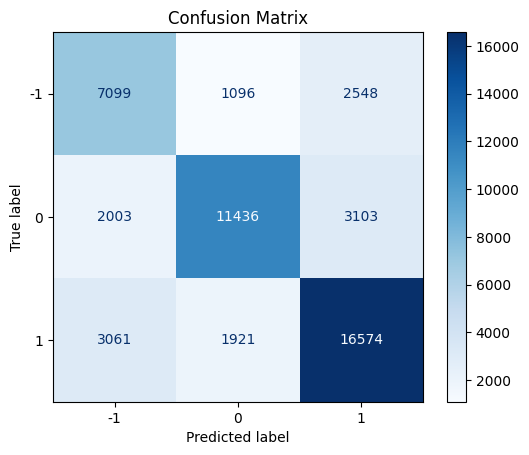

In [5]:
cm = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, cmap="Blues", display_labels=[-1, 0, 1]
)
plt.title("Confusion Matrix")
plt.show()

The baseline model achieves an accuracy of 71.88%. Performance varies noticeably across classes.

- The model struggles most with class −1, showing both a high number of incorrect predictions and missed true instances, indicating low precision and recall. \
- For class 0, predictions are generally correct when made, but the model fails to identify a substantial portion of actual class 0 samples, resulting in lower recall.
- In contrast, the model performs well on class 1, exhibiting both high accuracy and strong recall.

These patterns are consistent with the class imbalance in the dataset, where minority classes tend to suffer weaker performance.


## **Error Analysis**


While the baseline results provide an overview of model performance, they do not explain why these errors occur. To better understand the model’s weaknesses we proceed with an error analysis focusing on misclassified samples.


We begin the error analysis by examining the most frequent words appearing in incorrectly classified samples for each predicted class. Specifically, we measure the percentage of documents in which each word appears among wrong predictions and rank these words by frequency. For comparison, we also compute the same statistics for correctly classified samples.

This analysis is motivated by the behavior of Multinomial Naive Bayes, where class predictions are strongly influenced by word occurrence probabilities. Highly frequent words can disproportionately affect posterior probabilities, potentially causing the model to favor an incorrect class. By contrasting word frequencies and rankings between wrong and correct predictions, we can identify terms that may be confusing the model or dominating class likelihoods.


In [7]:
compare_word_usage_wrong_vs_right(y_pred, X_test, y_test, bow, label=-1, top_n=10)

,word,wrong_label_rank,wrong_word_pct,right_label_rank,right_word_pct
15971,modi,1,5.431,1,5.457
11771,india,2,0.851,2,0.939
797,all,3,0.841,3,0.755
20220,people,4,0.693,4,0.714
14352,like,5,0.632,5,0.607
2975,bjp,6,0.564,8,0.498
5101,congress,6,0.564,7,0.503
51,about,7,0.511,9,0.443
19310,only,8,0.468,11,0.419
10112,govt,9,0.457,10,0.424


In [8]:
compare_word_usage_wrong_vs_right(y_pred, X_test, y_test, bow, label=0, top_n=10)

,word,wrong_label_rank,wrong_word_pct,right_label_rank,right_word_pct
15971,modi,1,6.377,1,8.233
11771,india,2,0.951,2,0.975
7680,election,3,0.656,9,0.562
2975,bjp,4,0.644,6,0.642
18411,narendra,5,0.634,3,0.802
5101,congress,6,0.612,7,0.612
18416,narendra modi,7,0.567,4,0.733
28170,vote,8,0.559,5,0.667
797,all,9,0.521,10,0.518
19310,only,10,0.442,8,0.576


In [10]:
compare_word_usage_wrong_vs_right(y_pred, X_test, y_test, bow, label=1, top_n=10)

,word,wrong_label_rank,wrong_word_pct,right_label_rank,right_word_pct
15971,modi,1,5.906,1,5.465
11771,india,2,1.383,2,1.404
797,all,3,0.805,3,0.707
2975,bjp,4,0.651,7,0.547
20220,people,5,0.609,6,0.548
14352,like,6,0.578,9,0.472
7680,election,7,0.527,12,0.463
28170,vote,8,0.526,10,0.467
5616,country,9,0.457,16,0.389
5101,congress,10,0.455,13,0.429


Examining the most frequent words in misclassified samples reveals that words common in wrong predictions are also common in correct predictions, and their document-level percentages are often similar. Many of the top words—such as "modi", "india", "all", "bjp", and "congress"—appear across all classes. This is expected given that the dataset was scraped for tweets relating to Indian politics before March 2021.

Although it is important to note that there are minor differences, such as `people` is frequent in classes `−1` and `1` but not in 0, `"narendra"` and `"narendra modi"` appear mostly in `0`, and `"election"` appears mainly in `0` and `1`.

These patterns suggest several insights:

1. Ambiguous words dominate misclassifications. Words that appear frequently in multiple classes create borderline predictions.
2. Shared high-frequency words have low discriminative power. For example, counts for "modi" are ranked 1st in all classes, meaning the model sees it everywhere, so it provides little information for distinguishing classes.
3. Less frequent words may be underweighted by smoothing. Rare words, which could help differentiate classes, may have reduced impact due to Laplace smoothing (α), which we will explore in later tuning.


Another potential source of error lies in words that appear in the test set but were never seen during training. Such unseen words can negatively impact the model’s predictions. To investigate this, we next analyze features that are unique to the test set and examine how they may contribute to misclassifications.


In [11]:
summary, unseen = report_unseen_test_words(X_train, X_test, bow, top_n=10)

print("Feature Sparsity Summary:")
for _, row in summary.iterrows():
    print(f"{row['Metric']}: {row['Value']}")

print("\nTop Unseen Words in Test Set:")
print(unseen)

Feature Sparsity Summary:
Total Features: 29318
Unseen Features in Test: 0
Percentage of Unseen Features: 0.00%
Total Test Docs: 48841
Test Docs with Unseen Features: 0
Percentage of Test Docs with Unseen Features: 0.00%

Top Unseen Words in Test Set:
Empty DataFrame
Columns: [Word, Count in Test]
Index: []


We examined words that appear in the test set but were never observed during training to determine if they contribute to misclassifications. No such words were found, indicating that the model’s errors are not caused by unseen vocabulary.


Since neither common words nor unseen test-specific words explain the misclassifications, the focus shifts to rare words that appear disproportionately in wrong predictions. These words, although infrequent overall, may have high predictive influence when they occur, making them likely contributors to the errors.


To identify such terms, we use the `lift` of each word, highlighting those that are overrepresented in misclassified samples relative to their overall frequency.

To calculate the lift we will use the class we will use **`compare_word_usage_wrong_vs_right()`**

> ADD DESCRIPTION OF THE FUNCTION LATER


In [13]:
report_misleading_words_by_lift(
    y_pred,
    X_test,
    y_test,
    bow,
    label=-1,
    lift_threshold=2.0,
    pct_wrong_threshold=0,
    top_n=10,
    min_docs=5,
).round(3)

,word,pct_wrong,lift
9092,flipkart,0.138,13823065.77
8282,evidence satellite,0.099,9873618.69
13117,job creator,0.099,9873618.69
26550,test simple,0.099,9873618.69
1662,arithmetic less,0.099,9873618.69
13965,late announcement,0.099,9873618.69
20546,petroleum,0.138,60.51
7466,dushman,0.099,43.22
25284,start bark,0.099,43.22
14240,less exist,0.099,43.22


In [14]:
report_misleading_words_by_lift(
    y_pred,
    X_test,
    y_test,
    bow,
    label=0,
    lift_threshold=2.0,
    pct_wrong_threshold=0,
    top_n=10,
    min_docs=5,
).round(3)

,word,pct_wrong,lift
19103,northeast stand,0.232,23201857.15
9047,firmly bjp,0.232,23201857.15
25252,stand firmly,0.232,53.16
17381,modi study,0.166,37.97
4903,complaint modi,0.166,25.31
790,alien,0.331,16.88
24052,sell pakoda,0.199,15.19
7549,eat beef,0.199,15.19
22703,release film,0.166,15.19
5026,confine,0.166,15.19


In [15]:
report_misleading_words_by_lift(
    y_pred,
    X_test,
    y_test,
    bow,
    label=1,
    lift_threshold=2.0,
    pct_wrong_threshold=0,
    top_n=10,
    min_docs=5,
).round(3)

,word,pct_wrong,lift
11010,help election,0.088,8847992.51
27280,tshirt modi,0.142,61.14
18757,need year,0.088,38.21
25504,stitch,0.088,38.21
4683,clout,0.088,38.21
14217,legit,0.088,38.21
18637,naya bharat,0.088,38.21
18481,nation few,0.106,22.93
14535,likely return,0.088,19.11
18641,nayyar,0.088,19.11


For class `"-1"`, the words with the highest lifts, such as `"flipkart"`, appear in an extremely small fraction of misclassified documents—less than 0.14%. These extreme-lift words highlight points of strong association with errors, yet their overall contribution is minimal due to their rarity. More moderate-lift words, like `"petroleum"`, `"dushman"`, and `"start bark"`, show up more consistently in misclassified documents, although its contributions are still minimal.

In class `"0"`, the pattern is similar but with some differences. The most extreme-lift words, including `"northeast stand"` and `"firmly bjp"`, also appear in only a tiny fraction of misclassified documents, while moderate-lift words such as `"stand firmly"`, `"modi study"`, `"alien"`, and `"sell pakoda"` occur more frequently. These moderate words hint at recurring—but weak—signals that the model may be struggling to interpret. Interestingly, class 0 shows a mix of politically associated terms and generic words, without a single dominant theme. Because this is a larger class, the errors are more distributed, and the average lift of these moderate words is lower than in class -1.

Class `"1"` shows a slightly different behavior. Extreme-lift words, such as `"help election"`, are again extremely rare, appearing in fewer than 0.15% of misclassified documents. Moderate-lift words like `"tshirt modi"`, `"clout"`, and `"legit"` occur more often, but not significant enoug. Class `"1"` demonstrates fewer extreme-lift words, which is consistent with its status as the majority class and its greater stability against rare-word effects.

Looking across all classes, a clear pattern emerges. Words with very high lifts are too rare to significantly drive misclassification, but they do indicate points where the model is particularly sensitive to unusual terms. Moderate-lift words, appearing more frequently (although it is still less than a precent), provide more insight into subtle sources of confusion. Notably, there is no obvious semantic theme within or between classes among these rare words, suggesting that misclassifications are influenced more by words that are much more frequent. The minority class, -1, is particularly sensitive to rare terms, while the majority class, 1, exhibits greater robustness against such rare-word effects.


While rare high-lift words highlight points of sensitivity, their low frequency limits their overall impact on model behavior. This motivates a shift in focus toward words that maintain a relatively high lift while appearing more frequently in misclassified samples. Such words strike a balance between influence and prevalence, making them more likely to meaningfully affect predictions. We therefore next examine words that are both common in wrong predictions and disproportionately associated with misclassification, to identify features that may consistently bias the model’s decisions.


In [12]:
report_misleading_words_by_lift(
    y_pred,
    X_test,
    y_test,
    bow,
    label=-1,
    lift_threshold=2.0,
    pct_wrong_threshold=1,
    top_n=10,
    min_docs=5,
).round(3)

,word,pct_wrong,lift
13221,journalist,1.639,3.37
14012,law,1.323,3.11
17118,modi promise,1.343,2.98
2386,bank,2.725,2.98
27496,unemployment,1.303,2.90
3206,blame modi,1.106,2.88
17813,money,5.964,2.84
25180,spread,1.323,2.75
8743,farmer,2.231,2.74
10886,hatred,1.224,2.73


In [16]:
report_misleading_words_by_lift(
    y_pred,
    X_test,
    y_test,
    bow,
    label=0,
    lift_threshold=2.0,
    pct_wrong_threshold=1,
    top_n=10,
    min_docs=5,
).round(3)

,word,pct_wrong,lift
4721,code conduct,2.121,4.67
2936,biopic,1.956,4.19
16161,modi biopic,1.028,4.06
22697,release,2.088,4.04
7702,election commission,1.690,4.01
8977,file,1.028,3.96
4720,code,2.652,3.95
4803,commission,2.221,3.94
1627,april,1.260,3.80
28071,violate,1.094,3.77


In [17]:
report_misleading_words_by_lift(
    y_pred,
    X_test,
    y_test,
    bow,
    label=1,
    lift_threshold=2.0,
    pct_wrong_threshold=1,
    top_n=10,
    min_docs=5,
).round(3)

,word,pct_wrong,lift


For class **−1**, commonly misclassified words (>1% of errors) reflect an **economic and livelihood-related theme** (e.g., _bank, unemployment, money, farmer_), often framed within political discourse (e.g., _blame modi, modi promise_). Although these words appear relatively often (up to ~6% of misclassified samples), their **moderate lift values (≈2.7–3.4)** indicate limited discriminative power. In MNB, such terms accumulate probability mass across multiple classes, increasing confusion when class-conditional word probabilities are similar.

For class **0**, frequent misclassified words are dominated by **institutional and procedural political language** (e.g., _code of conduct, election commission, violate_). Frequencies are comparable to class −1, while lift values remain moderate (≈3.8–4.7), suggesting that these terms blur class boundaries rather than strongly favoring a single label.

For class **1**, no words meet the frequency threshold. This suggests that misclassifications for this class are **not driven by recurring tokens**, but are instead dominated by **rare or sparsely observed words**, consistent with earlier rare-word error analysis.


Taken together, these analyses suggest that misclassifications in the baseline Multinomial Naive Bayes model cannot be fully explained by word-level behavior alone. High-frequency words lack discriminative power, extreme-lift rare words are too sparse to meaningfully drive errors, and moderate-lift words provide only weak and inconsistent signals across classes. While the minority class (−1) appears more sensitive to rare terms, the majority class (1) exhibits greater robustness, with its errors not attributable to any recurring vocabulary pattern.

This asymmetry points to a broader structural issue in the learning process. The model is trained on a dataset with substantial class imbalance, where class 1 has nearly twice as many samples as class −1. In such settings, Multinomial Naive Bayes estimates class-conditional probabilities and priors that inherently favor majority classes, even when lexical evidence is ambiguous. As a result, borderline documents—especially those containing common or weakly discriminative words—are more likely to be absorbed into the dominant class.

Therefore, beyond token-level effects, the observed error patterns suggest that class imbalance may be systematically biasing the model’s predictions. This motivates the next step of the analysis: addressing dataset imbalance and examining whether rebalancing the class distribution can reduce misclassification rates, particularly for the minority class.


# **Balancing Data**


In [22]:
bal_model = MultinomialNB(alpha=0)

bal_model.fit(Xb_train, yb_train)

ybal_pred = bal_model.predict(X_test)

report_classification_performance(bal_model, y_pred, y_test)

Accuracy: 0.7322536393603735

Classification Report:

              precision    recall  f1-score   support

          -1     0.5399    0.8280    0.6536     10743
           0     0.8267    0.7105    0.7642     16542
           1     0.8328    0.7012    0.7614     21556

    accuracy                         0.7323     48841
   macro avg     0.7332    0.7466    0.7264     48841
weighted avg     0.7663    0.7323    0.7386     48841



a:\College\Year 3\Term 2\STINTSY\STINTSY-Order-of-Erin\.venv\Lib\site-packages\sklearn\naive_bayes.py:930: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(


array([ 0,  0,  0, ..., -1, -1,  0], shape=(48841,))

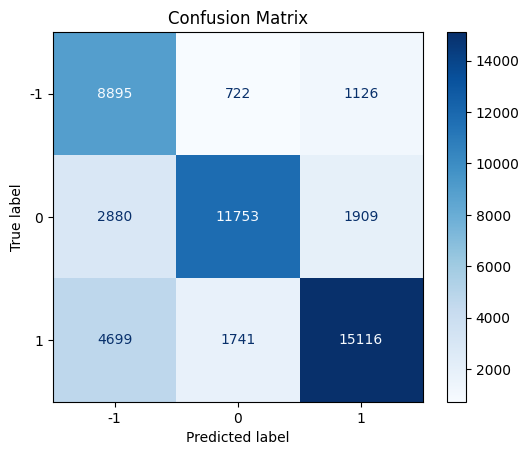

In [23]:
cm = ConfusionMatrixDisplay.from_predictions(
    y_test, ybal_pred, cmap="Blues", display_labels=[-1, 0, 1]
)
plt.title("Confusion Matrix")
plt.show()

Even after balancing the data, -1 that used to be the minority class precission got reduced, showing that


: 

: 

: 

: 

: 

: 

In [ ]:
summary, top_unseen = report_unseen_test_words(X_train, X_test, bow, top_n=20)

print("\nFeature Sparsity Summary:\n")
for _, row in summary.iterrows():
    print(f"{row['Metric']}: {row['Value']}")

print("\nTop Unseen Words in Test:\n")
print(top_unseen)


Feature Sparsity Summary:

Total Features: 29318
Unseen Features in Test: 0
Percentage of Unseen Features: 0.00%
Total Test Docs: 48841
Test Docs with Unseen Features: 0
Percentage of Test Docs with Unseen Features: 0.00%

Top Unseen Words in Test:

Empty DataFrame
Columns: [Word, Count in Test]
Index: []


: 

: 

: 

: 

: 

: 

No unseed words. so does not need to rely on prior belifes (guess ig?) to determine. Errors are not caused by new words


In [ ]:
param_grid = {"alpha": [0.01, 0.1, 0.5, 1, 5, 10]}
model = MultinomialNB()

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(model, param_grid, cv=kf, scoring="accuracy")
grid.fit(X_train, y_train)

print("Best alpha:", grid.best_params_["alpha"])
print("Best CV accuracy:", grid.best_score_)

best_model = grid.best_estimator_

Best alpha: 1
Best CV accuracy: 0.7231221481221481


: 

: 

: 

: 

: 

: 

: 

# Further Evaluation
